In [ ]:
%pip install llama-index-multi-modal-llms-openai
%pip install llama-index-vector-stores-lancedb
%pip install llama-index-embeddings-clip

In [ ]:
%pip install llama_index ftfy regex tqdm
%pip install -U openai-whisper
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install lancedb
%pip install moviepy
%pip install pytube
%pip install pydub
%pip install SpeechRecognition
%pip install ffmpeg-python
%pip install soundfile

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-svumql98
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-svumql98
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


  if event.key is 'enter':



Moviepy - Writing frames ./mixed_data/frame%04d.png.


Moviepy - Done writing frames ./mixed_data/frame%04d.png.
MoviePy - Writing audio in ./mixed_data/output_audio.wav


MoviePy - Done.


100%|███████████████████████████████████████| 139M/139M [00:04<00:00, 34.3MiB/s]


Text data saved to file
Audio file removed


100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 91.4MiB/s]


**Node ID:** 9a66b80b-aff6-45e2-a240-9b88eefa7048<br>**Similarity:** 0.5843880772590637<br>**Text:** Good girl, good girl. Being a CEO means being a collaborator and a nurturer. But you have to be a work. Everyone is just waiting for me to buckle into the pressure. Is now a guitar introduced to th...<br>

Response to first query:
('Based on the context provided and the images from the video, it appears that '
 "the video might potentially violate YouTube's Community Guidelines, "
 'particularly those concerning harassment, bullying, and potentially harmful '
 'or dangerous content. The dialogue excerpts suggest themes of power '
 'dynamics, inappropriate behavior, and possibly coercive situations, which '
 'could be interpreted as content that promotes harassment or abuse.\n'
 '\n'
 'For instance, phrases like "Get on your knees now," and "I think you like to '
 'be told what to do," imply a power imbalance and could be seen as promoting '
 "or glorifying harassment or abusive behavior. YouTube's guidelines are quite "
 'strict regarding content that might be harmful or dangerous, as well as '
 'content that harasses or bullies individuals.\n'
 '\n'
 'Furthermore, the overall tone and context of the dialogue, combined with the '
 'intense and possibly confrontational scenes shown in the

**Node ID:** 9a66b80b-aff6-45e2-a240-9b88eefa7048<br>**Similarity:** 0.6006999015808105<br>**Text:** Good girl, good girl. Being a CEO means being a collaborator and a nurturer. But you have to be a work. Everyone is just waiting for me to buckle into the pressure. Is now a guitar introduced to th...<br>


Response to follow-up query:
('Yes, the video suggests content that may be age-restricted based on the '
 'dialogue and scenarios presented. The dialogue includes phrases that imply '
 'power dynamics and potentially inappropriate behavior, such as "Get on your '
 'knees now," and "Does it turn you on when it\'s good?" These lines suggest '
 'themes of dominance, submission, and possibly sexual undertones, which are '
 'typically considered suitable for a mature audience. Additionally, the '
 'context of a CEO and power dynamics in the workplace can also touch on '
 'sensitive themes that are generally addressed in films or content rated for '
 'older viewers.')


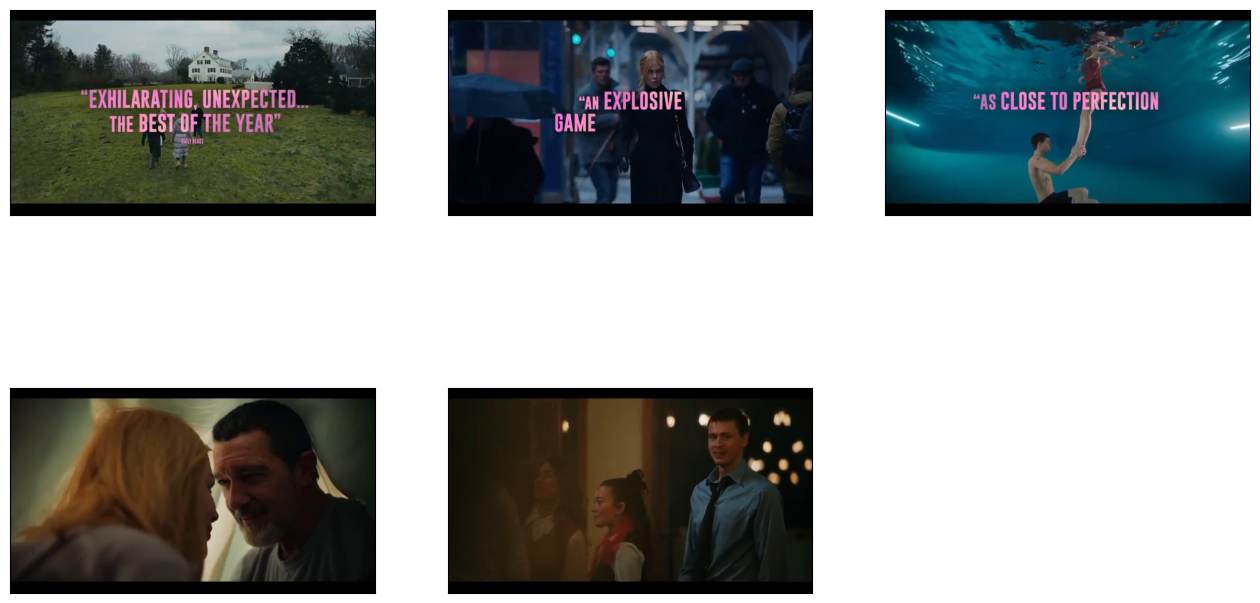

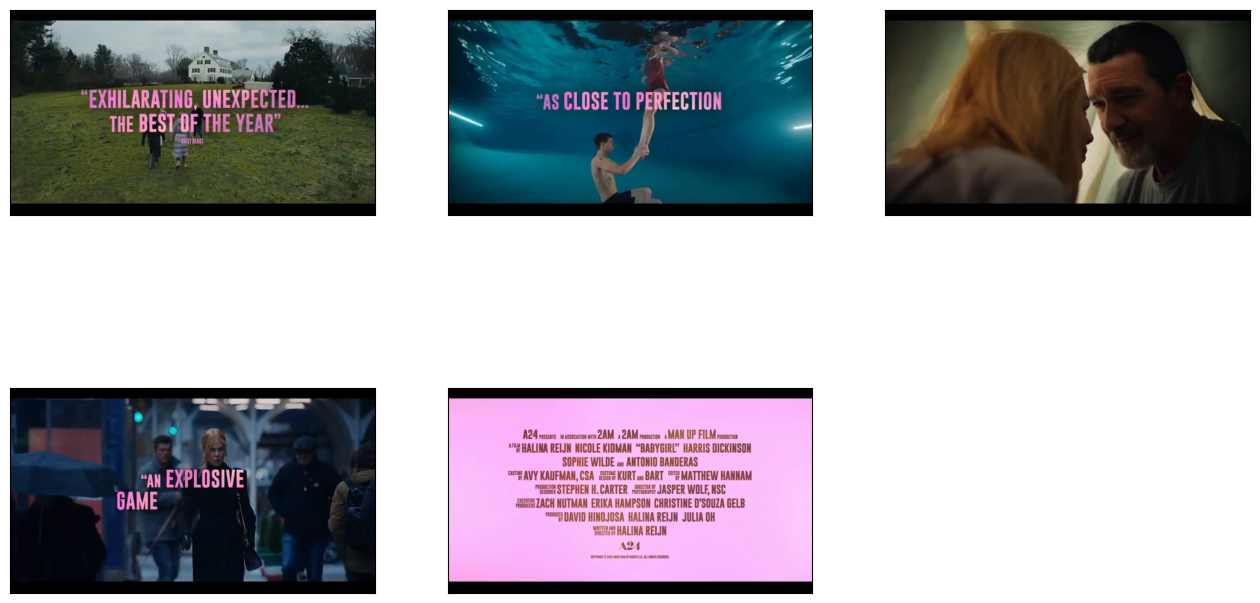

In [ ]:

from moviepy.editor import VideoFileClip
from pathlib import Path
import speech_recognition as sr
from pprint import pprint
import os
import json
from PIL import Image
import matplotlib.pyplot as plt

# Set up OpenAI API key
OPENAI_API_KEY = "your_key_here"
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

# Define input and output paths
input_video_path = "/content/nicole_trailer.mp4"  # 'babygirl' movie trailer used here, no copyright infringment intended, for educational purposes only # Change this to your local mp4 file path
output_folder = "./mixed_data/"
output_audio_path = "./mixed_data/output_audio.wav"

# Create output folder if it doesn't exist
Path(output_folder).mkdir(parents=True, exist_ok=True)

def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)
            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            images_shown += 1
            if images_shown >= 7:
                break

def video_to_images(video_path, output_folder):
    clip = VideoFileClip(video_path)
    clip.write_images_sequence(
        os.path.join(output_folder, "frame%04d.png"), fps=0.2
    )

def video_to_audio(video_path, output_audio_path):
    clip = VideoFileClip(video_path)
    audio = clip.audio
    audio.write_audiofile(output_audio_path)

def audio_to_text(audio_path):
    recognizer = sr.Recognizer()
    audio = sr.AudioFile(audio_path)
    with audio as source:
        audio_data = recognizer.record(source)
        try:
            text = recognizer.recognize_whisper(audio_data)
        except sr.UnknownValueError:
            print("Speech recognition could not understand the audio.")
        except sr.RequestError as e:
            print(f"Could not request results from service; {e}")
    return text

# Main processing
try:
    video_to_images(input_video_path, output_folder)
    video_to_audio(input_video_path, output_audio_path)
    text_data = audio_to_text(output_audio_path)

    with open(output_folder + "output_text.txt", "w") as file:
        file.write(text_data)
    print("Text data saved to file")

    os.remove(output_audio_path)
    print("Audio file removed")

except Exception as e:
    raise e

from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.vector_stores.lancedb import LanceDBVectorStore

text_store = LanceDBVectorStore(uri="lancedb", table_name="text_collection")
image_store = LanceDBVectorStore(uri="lancedb", table_name="image_collection")
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader(output_folder).load_data()

index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)
retriever_engine = index.as_retriever(
    similarity_top_k=5, image_similarity_top_k=5
)

# Create basic metadata for the local video file
metadata_vid = {
    "FileName": os.path.basename(input_video_path),
    "FileSize": os.path.getsize(input_video_path)
}

metadata_str = json.dumps(metadata_vid)

qa_tmpl_str = (
    "Given the provided information, including relevant images and retrieved context from the video, \
 accurately and precisely answer the query without any additional prior knowledge.\n"
    "Please ensure honesty and responsibility, refraining from any racist or sexist remarks.\n"
    "---------------------\n"
    "Context: {context_str}\n"
    "Video File Metadata: {metadata_str} \n"
    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

def retrieve(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

from llama_index.multi_modal_llms.openai import OpenAIMultiModal

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-turbo", api_key=OPENAI_API_KEY, max_new_tokens=1500
)

def process_query(query_str, retriever_engine, openai_mm_llm, metadata_str):
    img, txt = retrieve(retriever_engine=retriever_engine, query_str=query_str)
    image_documents = SimpleDirectoryReader(
        input_dir=output_folder, input_files=img
    ).load_data()
    context_str = "".join(txt)
    plot_images(img)

    response = openai_mm_llm.complete(
        prompt=qa_tmpl_str.format(
            context_str=context_str, query_str=query_str, metadata_str=metadata_str
        ),
        image_documents=image_documents,
    )

    return response.text

# First query
query_str_1 = "Using examples from video, does this video appear to comply with all YouTube Community Guidelines? If so, explain why. If not, which guidelines might it violate?"
response_1 = process_query(query_str_1, retriever_engine, openai_mm_llm, metadata_str)

print("Response to first query:")
pprint(response_1)

# Follow-up query
query_str_2 = "Using examples from video, does this video suggest any age-restricted content?"
response_2 = process_query(query_str_2, retriever_engine, openai_mm_llm, metadata_str)

print("\nResponse to follow-up query:")
pprint(response_2)

# You can add more queries as needed, for example:
# query_str_3 = "What are the limitations of the gaussian function discussed in the video?"
# response_3 = process_query(query_str_3, retriever_engine, openai_mm_llm, metadata_str)
# print("\nResponse to third query:")
# pprint(response_3)


**Node ID:** 9a66b80b-aff6-45e2-a240-9b88eefa7048<br>**Similarity:** 0.5905096530914307<br>**Text:** Good girl, good girl. Being a CEO means being a collaborator and a nurturer. But you have to be a work. Everyone is just waiting for me to buckle into the pressure. Is now a guitar introduced to th...<br>


Response to third query:
('The credits for the movie from the video are as follows:\n'
 '\n'
 '- Directed by Halina Reijn\n'
 '- Written by Halina Reijn & Joost van Ginkel\n'
 '- Produced by David Hinojosa, Christine Vachon, Pamela Koffler, and Katie '
 'McNeill\n'
 '- Executive Producers: Stephen C. Carter, Jasper Wolf, NSC\n'
 '- A 2AM and Nicole Kidman Production\n'
 '- In Association with Anton, Barder, and FilmNation\n'
 '- Cast includes Nicole Kidman, Amy Harris, and others')


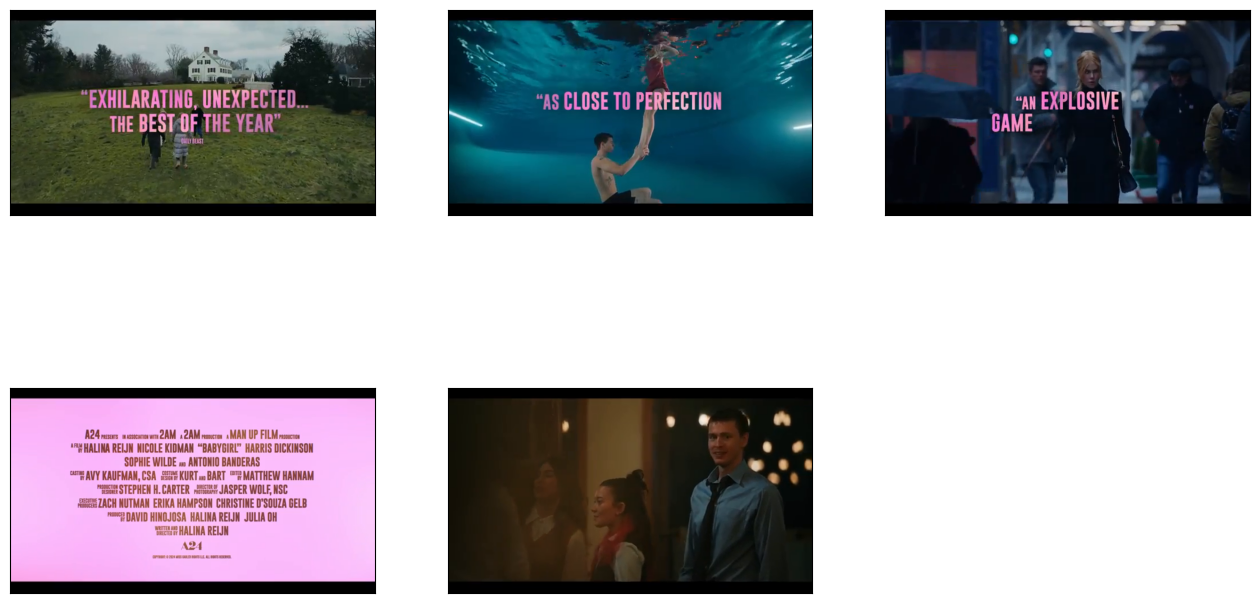

In [ ]:
query_str_3 = "Based on the video, give me the credits of the movie"
response_3 = process_query(query_str_3, retriever_engine, openai_mm_llm, metadata_str)
print("\nResponse to third query:")
pprint(response_3)

**Node ID:** 9a66b80b-aff6-45e2-a240-9b88eefa7048<br>**Similarity:** 0.5822000503540039<br>**Text:** Good girl, good girl. Being a CEO means being a collaborator and a nurturer. But you have to be a work. Everyone is just waiting for me to buckle into the pressure. Is now a guitar introduced to th...<br>


Response to third query:
('The reviews for the movie from the video include:\n'
 '\n'
 '1. "Exhilarating, unexpected. The best of the year" - Daily Beast\n'
 '2. "As close to perfection"\n'
 '3. "An explosive game"\n'
 '\n'
 'These reviews suggest that the movie has been well-received, highlighting '
 'its thrilling and exceptional quality.')


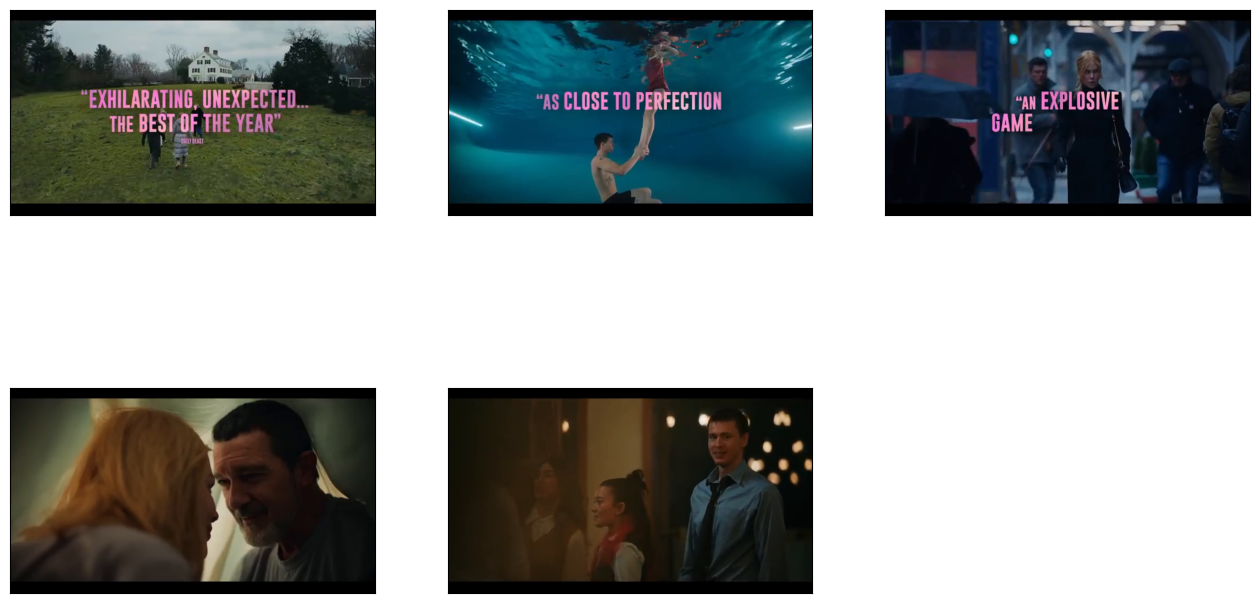

In [ ]:
query_str_4 = "Based on the video, give me the reviews for the movie"
response_4 = process_query(query_str_4, retriever_engine, openai_mm_llm, metadata_str)
print("\nResponse to third query:")
pprint(response_4)

Starting video analysis...
Processing compliance check query...


**Node ID:** 9a66b80b-aff6-45e2-a240-9b88eefa7048<br>**Similarity:** 0.5843880772590637<br>**Text:** Good girl, good girl. Being a CEO means being a collaborator and a nurturer. But you have to be a work. Everyone is just waiting for me to buckle into the pressure. Is now a guitar introduced to th...<br>

Processing age restriction check query...


**Node ID:** 9a66b80b-aff6-45e2-a240-9b88eefa7048<br>**Similarity:** 0.6006999015808105<br>**Text:** Good girl, good girl. Being a CEO means being a collaborator and a nurturer. But you have to be a work. Everyone is just waiting for me to buckle into the pressure. Is now a guitar introduced to th...<br>

Processing movie review extraction query...


**Node ID:** 9a66b80b-aff6-45e2-a240-9b88eefa7048<br>**Similarity:** 0.5822000503540039<br>**Text:** Good girl, good girl. Being a CEO means being a collaborator and a nurturer. But you have to be a work. Everyone is just waiting for me to buckle into the pressure. Is now a guitar introduced to th...<br>


Generated Report:
{
  "timestamp": "2024-10-20T00:22:54.256339",
  "compliance_check": {
    "result": "Based on the context provided and the images from the video, it appears that the video might potentially violate some of YouTube's Community Guidelines, particularly those related to harassment, cyberbullying, and potentially harmful or dangerous content. The dialogue and scenes suggest themes of power dynamics, inappropriate behavior, and possibly coercion, which could be interpreted as content that promotes harassment or emotional distress.\n\n1. **Harassment and Cyberbullying**: YouTube's guidelines prohibit content that intends to harass, threaten, or bully individuals. The dialogue in the video, such as \"Get on your knees now,\" and \"I tell you what to do and you do it,\" could be seen as promoting or glorifying harassment or abusive behavior.\n\n2. **Harmful or Dangerous Content**: The guideline also covers content that encourages harmful or dangerous behaviors. The power dy

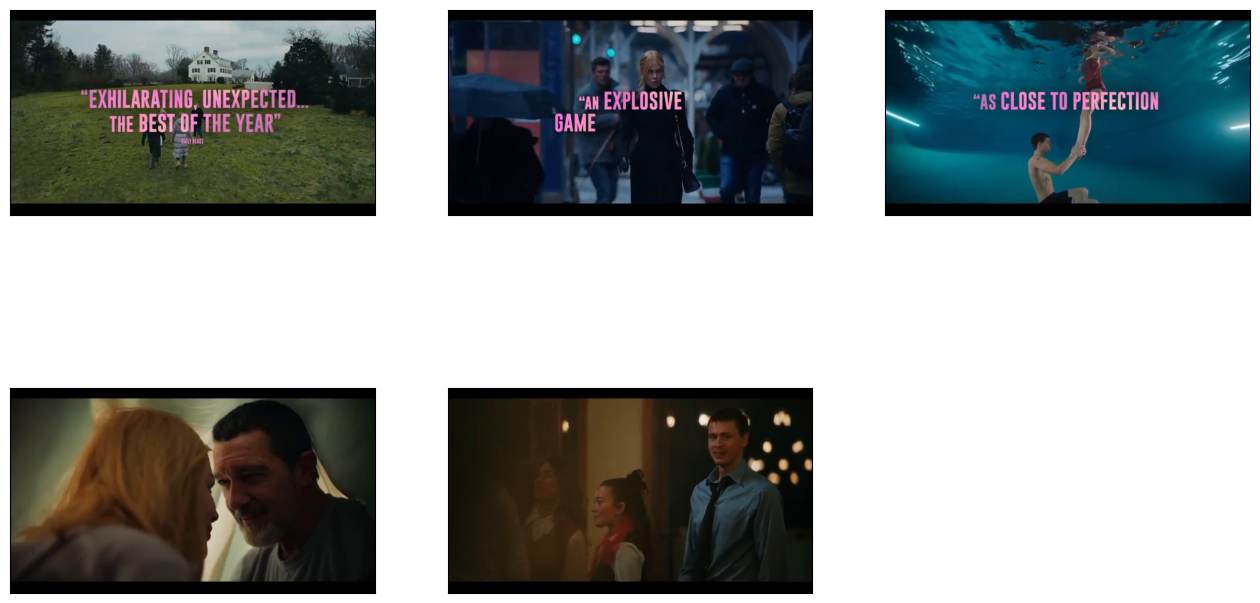

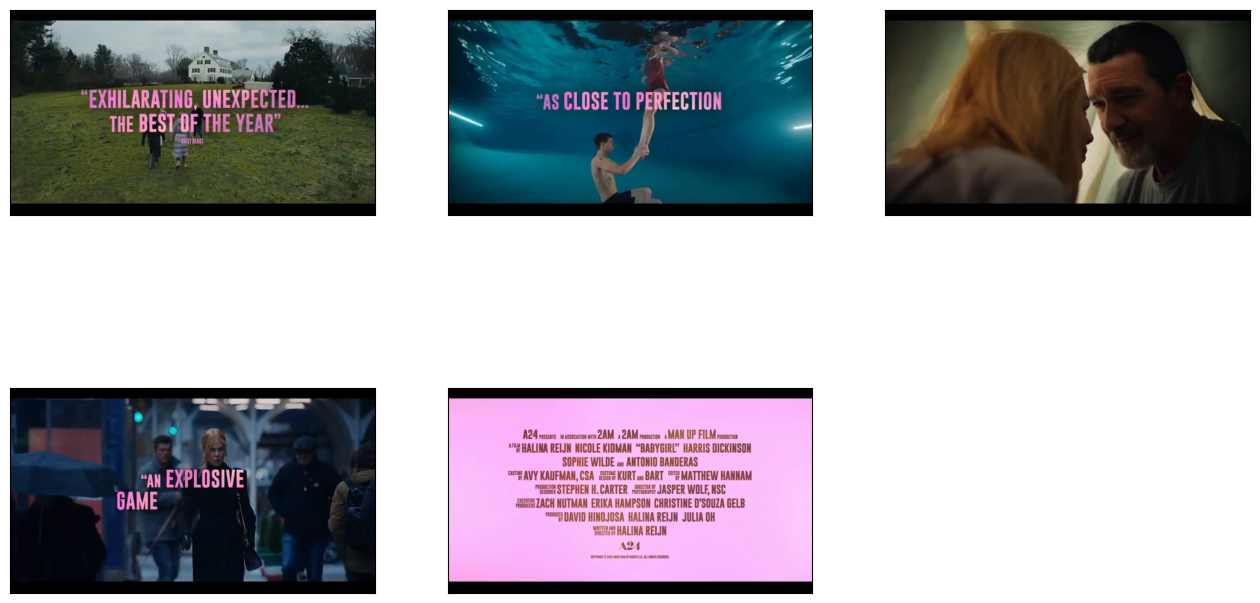

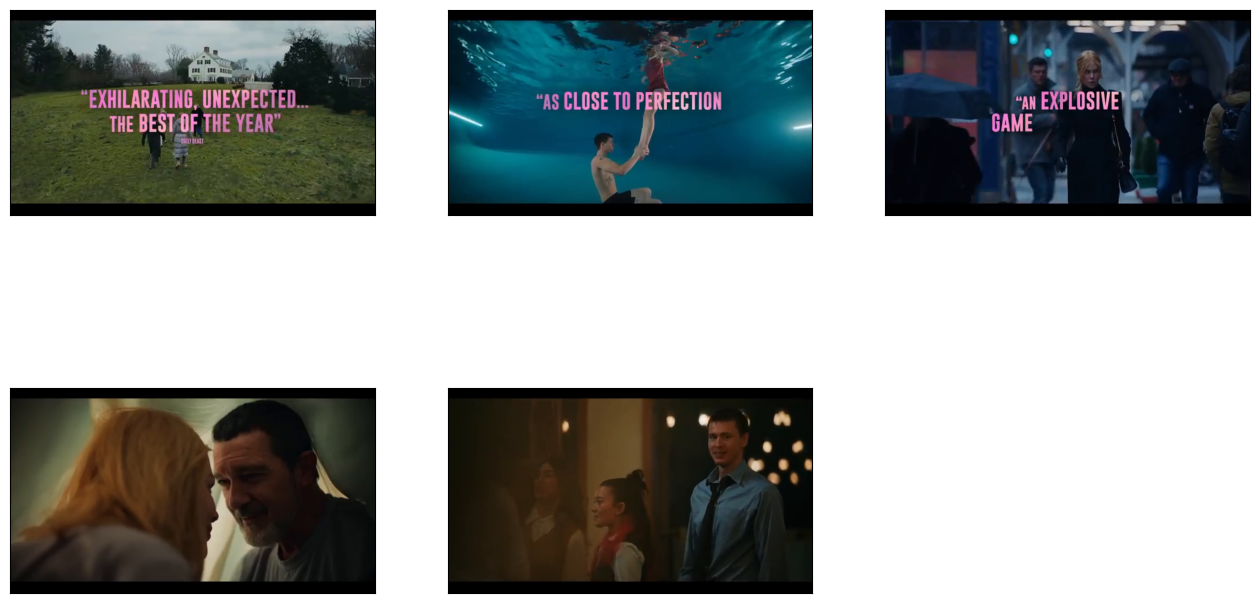

In [ ]:
# New imports
import json
from datetime import datetime

# New functions for report generation and analysis
def generate_report(compliance_response, age_restriction_response, review_response):
    report = {
        "timestamp": datetime.now().isoformat(),
        "compliance_check": {
            "result": compliance_response,
            "compliant": "comply" in compliance_response.lower()
        },
        "age_restriction_check": {
            "result": age_restriction_response,
            "age_restricted": "age-restricted" in age_restriction_response.lower()
        },
        "movie_review": {
            "review": review_response
        }
    }
    return report

def analyze_results(report):
    actions = []
    if not report["compliance_check"]["compliant"]:
        actions.append("Flag video for manual review due to potential guideline violation.")
    if report["age_restriction_check"]["age_restricted"]:
        actions.append("Apply age restriction to the video.")
    if len(report["movie_review"]["review"]) < 50:  # Arbitrary length for this example
        actions.append("Review extraction may have failed. Check video content manually.")
    return actions

# Process and analyze video function
def process_and_analyze_video(query_str_1, query_str_2, query_str_4, retriever_engine, openai_mm_llm, metadata_str):
    print("Processing compliance check query...")
    response_1 = process_query(query_str_1, retriever_engine, openai_mm_llm, metadata_str)
    print("Processing age restriction check query...")
    response_2 = process_query(query_str_2, retriever_engine, openai_mm_llm, metadata_str)
    print("Processing movie review extraction query...")
    response_4 = process_query(query_str_4, retriever_engine, openai_mm_llm, metadata_str)

    report = generate_report(response_1, response_2, response_4)
    actions = analyze_results(report)

    print("\nGenerated Report:")
    print(json.dumps(report, indent=2))
    print("\nSuggested Actions:")
    for action in actions:
        print(f"- {action}")

    return report, actions

# Run the analysis
print("Starting video analysis...")
query_str_1 = "Using examples from video, does this video appear to comply with all YouTube Community Guidelines? If so, explain why. If not, which guidelines might it violate?"
query_str_2 = "Using examples from video, does this video suggest any age-restricted content?"
query_str_4 = "Based on the video, give me the reviews for the movie"

report, actions = process_and_analyze_video(query_str_1, query_str_2, query_str_4, retriever_engine, openai_mm_llm, metadata_str)
print("Video analysis completed.")